In [ ]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Pauli matrices
σx = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
σy = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
σz = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
σp = (σx + 1j*σy) / 2  # raising
σm = (σx - 1j*σy) / 2  # lowering

def place(op, site, N):
    """
    Place single-site operator `op` at position `site` in an N-site chain.
    op: 2x2 sparse matrix
    site: int, 0-based site index
    N: total number of sites
    """
    mats = []
    for i in range(N):
        mats.append(op if i == site else sp.eye(2, format='csr', dtype=complex))
    # Tensor product
    result = mats[0]
    for m in mats[1:]:
        result = sp.kron(result, m, format='csr')
    return result

# 1) Build spin-ladder Hamiltonian (open boundaries)
def build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q):
    """
    Build the many-body Hamiltonian for an open spin ladder of L unit cells (2L sites).
    """
    N_sites = 2 * L
    g_qc = np.sqrt(g_q * g_c)
    H = sp.csr_matrix((2**N_sites, 2**N_sites), dtype=complex)
    
    for n in range(L):
        ia = 2*n      # cavity-leg site index
        ib = ia + 1   # qubit-leg site index
        
        # Onsite sigma_z terms
        H += (omega_c/2) * place(σz, ia, N_sites)
        H += (omega_q/2) * place(σz, ib, N_sites)
        
        # Rung coupling g_Φ: flip-flop between a_n and b_n
        H +=  g_Φ * (place(σp, ib, N_sites) @ place(σm, ia, N_sites) +
                     place(σm, ib, N_sites) @ place(σp, ia, N_sites))
        
        # Only add inter-cell terms if not last cell (open BC)
        if n < L-1:
            ia_next = ia + 2
            ib_next = ib + 2
            # cavity leg hopping +g_c
            H +=  g_c * (place(σp, ia, N_sites) @ place(σm, ia_next, N_sites) +
                         place(σm, ia, N_sites) @ place(σp, ia_next, N_sites))
            # qubit leg hopping -g_q
            H += -g_q * (place(σp, ib, N_sites) @ place(σm, ib_next, N_sites) +
                         place(σm, ib, N_sites) @ place(σp, ib_next, N_sites))
            # diagonals sqrt(g_q g_c)
            H += -g_qc * (place(σp, ib, N_sites) @ place(σm, ia_next, N_sites) +
                          place(σm, ib, N_sites) @ place(σp, ia_next, N_sites))
            H +=  g_qc * (place(σp, ia, N_sites) @ place(σm, ib_next, N_sites) +
                          place(σm, ia, N_sites) @ place(σp, ib_next, N_sites))
    return H

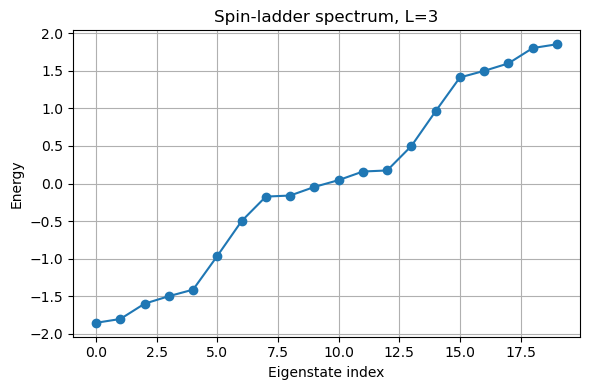

In [93]:
# Example parameters
L = 3
N_sites = 2 * L
omega_c = 4.0
omega_q = 1.0
g_Φ = 0.0
g_c = 1.0
g_q = 1.0

# Build and diagonalize
H_spin = build_H_spin(L, omega_c, omega_q, g_Φ, g_c, g_q)

# Use sparse eigensolver to find lowest few eigenstates
k_eigs = 20  # how many eigenvalues
eigs, vecs = spla.eigsh(H_spin, k=k_eigs, which='SM')  # smallest algebraic

# Sort eigenvalues
idx = np.argsort(np.real(eigs))
eigs = eigs[idx]

# Plot spectrum
plt.figure(figsize=(6,4))
plt.plot(np.arange(k_eigs), np.real(eigs), 'o-')
plt.xlabel('Eigenstate index')
plt.ylabel('Energy')
plt.title(f'Spin-ladder spectrum, L={L}')
plt.tight_layout()
plt.show()


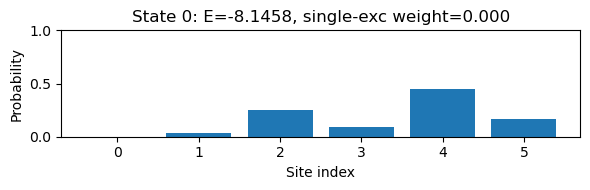

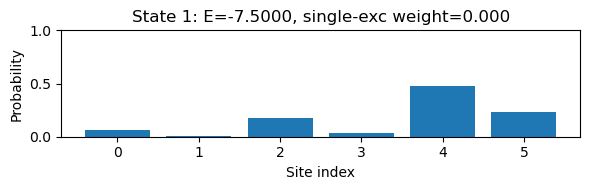

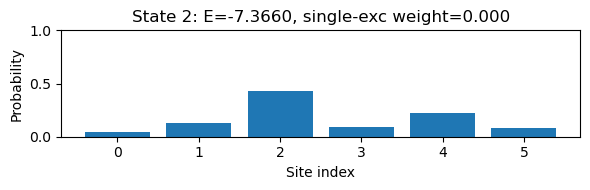

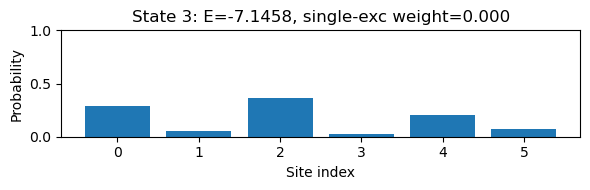

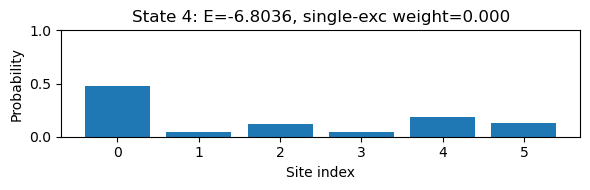

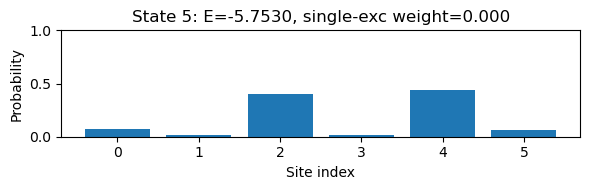

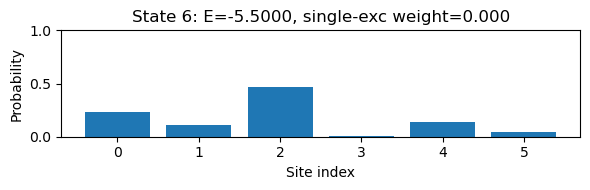

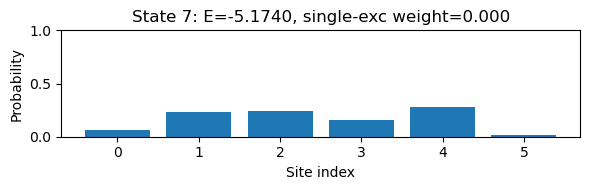

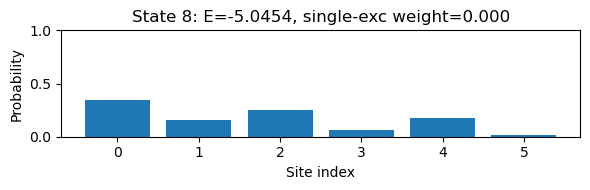

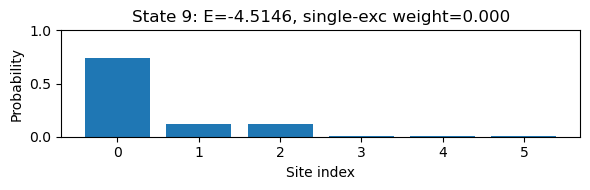

In [110]:
# -------------- Diagonalize Lowest States --------------
num_states = 10
eigvals, eigvecs = spla.eigsh(H_spin, k=num_states, which='SA')
order = np.argsort(eigvals)
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# -------------- Single-Excitation Projection --------------
# Identify basis indices with exactly one spin-up (bit '1')
single_exc_indices = [i for i in range(2**N_sites) if bin(i).count('1') == 1]

for idx_state in range(num_states):
    psi = eigvecs[:, idx_state]
    weights = np.abs(psi[single_exc_indices])**2
    total_weight = weights.sum()
    
    # site probability distribution
    prob = np.zeros(N_sites)
    for basis_idx, w in zip(single_exc_indices, weights):
        site = int(np.log2(basis_idx))
        prob[site] += w
    prob /= total_weight
    
    # Plot
    plt.figure(figsize=(6, 2))
    plt.bar(range(N_sites), prob)
    plt.title(f"State {idx_state}: E={eigvals[idx_state]:.4f}, single-exc weight={total_weight:.3f}")
    plt.xlabel("Site index")
    plt.ylabel("Probability")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
